# Import Packages

## Standard Packages

In [1]:
from operator import add
import math
import re
import time

## Installed Packages

In [2]:
import pandas as pd

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

In [4]:
import pyspark.sql.functions as F

In [5]:
import networkx as nx

In [88]:
import numpy as np

# Start Spark Session

In [6]:
sc = SparkContext()
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

# Config

In [7]:
fuzzyjoin_data_dir = 'dblp-small'
fuzzyjoin_similarity_name = 'Jaccard'
fuzzyjoin_similarity_threshold = 0.8
fuzzyjoin_record_data = '2,3'
fuzzyjoin_data_norecords = 100

# Custom Functions

## String Cleaning

In [8]:
def remove_punctuation(A):
    return re.sub(pattern=r"[^\w]", repl=" ", string=A)
# TODO: Note that this would remove tokens such as "C++"

In [9]:
assert remove_punctuation(A='Multimedia Databases.') == 'Multimedia Databases '

In [10]:
assert remove_punctuation(A='Multimedia Databases ¾') == 'Multimedia Databases ¾'

In [11]:
def normalize_case(A):
    return A.lower()

In [12]:
assert normalize_case('Multimedia Databases ') == 'multimedia databases '

In [13]:
def trim(A):
    A = re.sub(pattern=r"\s{2,}", repl=" ", string=A)
    A = A.strip()
    return A

In [14]:
assert trim('Multimedia Databases ') == 'Multimedia Databases'

In [15]:
assert trim('Multimedia   Databases ') == 'Multimedia Databases'

In [16]:
assert trim(' Multimedia Databases ') == 'Multimedia Databases'

In [17]:
def string_cleaning(A):
    A = remove_punctuation(A)
    A = normalize_case(A)
    A = trim(A)
    return A

In [18]:
assert string_cleaning(A='Multimedia Databases.') == 'multimedia databases'

## Tokenization

In [19]:
def split_tokens(A, delim=" "):
    return A.split(delim)

In [20]:
assert split_tokens(A="I will call back", delim=" ") == ["I", "will", "call", "back"]

In [21]:
def add_token_counts(A, sep="_"):
    A = sorted(A)
    
    current_token_count = 1
    for i, token in enumerate(A):
        total_token_count = A.count(token)
        A[i] = token+sep+str(current_token_count)
        if total_token_count > 1:
            current_token_count += 1
        else:
            current_token_count = 1
    
    return(A)

In [22]:
assert add_token_counts(A=["I", "will", "call", "back"], sep="_") == ["I_1", "back_1", "call_1", "will_1"]

In [23]:
assert add_token_counts(A=["Dan", "Schonfeld", "Dan", "Lelescu"], sep="_") == ["Dan_1", "Dan_2", "Lelescu_1", "Schonfeld_1"]

In [24]:
def tokenization(A, token_delim=" ", token_sep="_"):
    # token_delim: Specifies how tokens should be split in input string
    # token_sep: Specifies how tokens should be separated from their counts
    token_list = split_tokens(A, delim=token_delim)
    token_count_list = add_token_counts(token_list, sep=token_sep)
    return token_count_list

In [25]:
assert tokenization(A="I will call back") == ["I_1", "back_1", "call_1", "will_1"]

## Similarity Functions

In [26]:
def jaccard_index(A, B):
    A = set(A)
    B = set(B)
    return len(A & B)/len(A | B)

In [27]:
assert jaccard_index(A=["I", "will", "call", "back"], B=["I", "will", "call", "soon"]) == 0.6

In [28]:
A = "VORTEX  Video Retrieval and Tracking from Compressed Multimedia Databases. Dan Schonfeld Dan Lelescu"
B = "VORTEX  Video Retrieval and Tracking from Compressed Multimedia Databases ¾ Visual Search Engine. Dan Schonfeld Dan Lelescu"
a = tokenization(string_cleaning(A))
b = tokenization(string_cleaning(B))
assert round(jaccard_index(a, b), 7) == 0.7647059

In [29]:
def overlap_similarity(A, B):
    A = set(A)
    B = set(B)
    return len(A & B)

In [30]:
assert overlap_similarity(A=["I", "will", "call", "back"], B=["I", "will", "call", "soon"]) == 3

## Distance Functions

In [31]:
def hamming_distance(A, B):
    A = set(A)
    B = set(B)
    
    return len((A - B) | (B - A))

In [32]:
assert hamming_distance(A=["B", "C", "D", "E", "F"], B=["A", "B", "C", "D", "E"]) == 2

## Prefix Filtering

In [33]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def jaccard_prefix_length(token_count):
    return token_count - math.ceil(fuzzyjoin_similarity_threshold * token_count) + 1

## Length Filtering

In [34]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def jaccard_length_filtering(A, B):
    # From https://who.rocq.inria.fr/Vassilis.Christophides/Big/local_copy/Finding_Similar_Items/a15-xiao.pdf
    # Page 15:6
    
    A = set(A)
    B = set(B)
    if fuzzyjoin_similarity_threshold * len(A) <= len(B):
        return True
    return False

In [35]:
assert jaccard_length_filtering(A=["I", "will", "call", "back"], B=["I"]) == False

## Positional Filtering

In [36]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def get_jaccard_position_filter_lower_bound(n_tokens_A, n_tokens_B):
    return math.ceil(fuzzyjoin_similarity_threshold * (n_tokens_A + n_tokens_B) / (1 + fuzzyjoin_similarity_threshold))

In [37]:
def dedup_list(X):
    temp = []
    [temp.append(x) for x in X if x not in temp]
    return temp

In [38]:
assert dedup_list(["I", "will", "call", "back", "I"]) == ['I', 'will', 'call', 'back']

In [39]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def jaccard_positional_filtering(A, B, token_stop):
    
    # position of the last gram in common on A
    position_A = A.index(token_stop)
    
    # position of the last gram in common on B
    position_B = B.index(token_stop)
    
    current_overlap_amount = overlap_similarity(A[0:position_A+1], B[0:position_B+1])
    
    min_unseen_tokens = min(len(A[position_A+1:]), len(B[position_B+1:]))
    
    threshold = get_jaccard_position_filter_lower_bound(len(A), len(B))
    if current_overlap_amount + min_unseen_tokens >= threshold:
        return True
    return False

In [40]:
#assert jaccard_positional_filtering(A=["B", "C", "D", "E", "F"], B=["A", "B", "C", "D", "E"], token_stop="B") == True

## Suffix Filtering

In [41]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def get_hamming_distance_upper_bound(n_tokens_A, n_tokens_B):
    return (2*n_tokens_B) - (2*get_jaccard_position_filter_lower_bound(n_tokens_A, n_tokens_B)) - (math.ceil(fuzzyjoin_similarity_threshold*n_tokens_B) - math.ceil(fuzzyjoin_similarity_threshold*n_tokens_A))

In [42]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def jaccard_partition(s, w, l, r):
    '''
    Returns the partition of list of tokens.
    From Algorithm 4 in https://who.rocq.inria.fr/Vassilis.Christophides/Big/local_copy/Finding_Similar_Items/a15-xiao.pdf

            Parameters:
                    s (list): An array of tokens, sorted based on global ordering
                    w (str): A token
                    l (int): Left bound of searching range
                    r (int): Right bound of searching range

            Returns:
                    partition_tuple (tuple): Two partitions of s:s_l and s_r,
                                             a flag f indicating whether w is in the searching range,
                                             and a flag diff indicating whether the probing token w is not found in s
    '''
    #import pdb; pdb.set_trace()
    order_lower_bound = token_ordering_list.index(s[l])
    order_token = token_ordering_list.index(w)
    order_upper_bound = token_ordering_list.index(s[r-1])
    
    if order_lower_bound > order_token or order_upper_bound < order_token:
        return ([], [], 0, 1)
    
    for i in range(l, r):
        if token_ordering_list.index(s[i]) <= order_token:
            p = i
        else:
            break
    
    s_l = s[:p]
    if s[p] == w:
        s_r = s[p+1:]
        diff = 0
    else:
        s_r = s[p:]
        diff = 1
    return (s_l, s_r, 1, diff)

In [43]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
# TODO: Is there an issue with indexing?
def get_hamming_distance_lower_bound(A, B, H_max, d):
    '''
    Returns the lower bound of Hamming distance between two strings.
    From Algorithm 3 in https://who.rocq.inria.fr/Vassilis.Christophides/Big/local_copy/Finding_Similar_Items/a15-xiao.pdf

            Parameters:
                    A (list): An array of tokens, sorted based on global ordering
                    B (list): An array of tokens, sorted based on global ordering
                    H_max (int): Maximum allowable Hamming distance between A and B
                    d (int): Current recursive depth

            Returns:
                    H (int): Lower bound of Hamming distance between A and B
    '''
    max_depth = 2
    length_diff = abs(len(A) - len(B))
    
    if d > max_depth or len(A) == 0 or len(B) == 0:
        return length_diff
    
    mid = math.ceil(len(B)/2)
    w = B[mid-1]
    offset = int((H_max - length_diff)/2)
    if len(A) < len(B):
        offset_l = 1
        offset_r = 0
    else:
        offset_l = 0
        offset_r = 1
    
    (B_l, B_r, f, diff) = jaccard_partition(B, w, mid, mid)
    (A_l, A_r, f, diff) = jaccard_partition(A, w, 
                                            mid - offset - (length_diff*offset_l), 
                                            mid + offset + (length_diff*offset_r))
    
    if f == 0:
        return H_max + 1
    
    H = abs(len(A_l) - len(B_l)) + abs(len(A_r) - len(B_r)) + diff
    if H > H_max:
        return H
    else:
        H_l = get_hamming_distance_lower_bound(A_l, B_l, H_max - abs(len(A_r) - len(B_r)) - diff, d + 1)
        H = H_l + abs(len(A_r) - len(B_r)) + diff
        if H <= H_max:
            H_r = get_hamming_distance_lower_bound(A_r, B_r, H_max - H_l - diff, d + 1)
            return H_l + H_r + diff
        else:
            return H

In [44]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
def jaccard_suffix_filter(A, B):
    A = dedup_list(A)
    B = dedup_list(B)
    
    H_max = get_hamming_distance_upper_bound(len(A), len(B))
    H_min = get_hamming_distance_lower_bound(A, B, H_max, 1)
    return H_min <= H_max

In [45]:
#A = ['heytens_1', 'amelia_1', 'rafiul_1', 'object_2', 'ahad_1', 'carlson_1', 'annevelink_1', 'implementation_1', 'sql_1', 'daniel_1', 'fishman_1', 'jurgen_1', 'l_1', 'kent_1', 'language_1', 'design_1', 'william_1', 'h_1', 'michael_1', 'databases_1', 'of_1', 'a_1', 'for_1', 'the_1', 'and_1', 'object_1']
#B = ['hoch_1', 'mahbod_1', 'w_2', 'brom_1', 'chow_1', 'tore_1', 'risch_1', 'iris_1', 'hasan_1', 'lyngbæk_1', 'neimat_1', 'wilkinson_1', 'waqar_1', 'leichner_1', 'anne_1', 'beech_1', 'connors_1', 'kevin_1', 'marie_1', 'annevelink_1', 'daniel_1', 'fishman_1', 'jurgen_1', 'c_2', 'dbms_1', 'ming_1', 'chien_1', 'davis_1', 'shan_1', 'overview_1', 's_1', 'tim_1', 'g_1', 'kent_1', 'w_1', 'william_1', 'c_1', 'h_1', 'j_1', 'peter_1', 'e_1', 'david_1', 'of_1', 'the_1']
#jaccard_suffix_filter(A, B)

# Load Dataset

In [46]:
df = spark.read.csv(path='dblp.raw.txt.gz', sep=':', 
                    schema='dblp_id STRING, publication_title STRING, authors STRING, other_info STRING')

In [47]:
df.show()

+--------------------+--------------------+--------------------+--------------------+
|             dblp_id|   publication_title|             authors|          other_info|
+--------------------+--------------------+--------------------+--------------------+
|books/acm/kim95/A...|Object SQL - A La...|Jurgen Annevelink...|2002-01-03 42-68 ...|
|books/acm/kim95/B...|OQL[C++]  Extendi...|    José A. Blakeley|2002-01-03 69-88 ...|
|books/acm/kim95/B...|Transaction Manag...|Yuri Breitbart He...|2004-03-08 573-59...|
|books/acm/kim95/C...|Multimedia Inform...|Stavros Christodo...|2002-01-03 318-33...|
|books/acm/kim95/D...|Active Database S...|Umeshwar Dayal Er...|2002-01-03 434-45...|
|books/acm/kim95/D...|Where Object-Orie...|Angelika Kotz Dit...|2002-01-03 238-25...|
|books/acm/kim95/G...|Distributed Datab...|Hector Garcia-Mol...|2002-01-03 477-49...|
|books/acm/kim95/G...|An Object-Oriente...|      Nathan Goodman|2002-01-03 216-23...|
|books/acm/kim95/K...|Cooperative Trans...|      Gail 

In [48]:
df.count()

1268017

## Take Random Sample of Dataset

In [49]:
df = df.sample(fraction=0.1)

In [50]:
df.count()

126620

# Generate Records

# Balance Records across Nodes

# Set-Similarity Self-Join

## Basic Token Ordering

### Phase 1

In [51]:
df = df.withColumn('join_attribute', 
                   F.trim(F.concat(F.when(F.isnull(df['publication_title']), '').otherwise(df['publication_title']), 
                            F.lit(' '), 
                            F.when(F.isnull(df['authors']), '').otherwise(df['authors'])
                           ))
                  )

#### Map

In [52]:
# TODO: Create a function for splitting tokens, based on given delimiter
token_maps = df.select('join_attribute').rdd.flatMap(lambda line: tokenization(string_cleaning(line[0]))).map(lambda token: (token, 1))

#### Combine/Reduce

In [53]:
token_reduce = token_maps.reduceByKey(add)

### Phase 2

#### Map

In [54]:
token_count_swap = token_reduce.map(lambda x: (x[1], x[0])).sortByKey()

#### Reduce

In [55]:
token_ordering = token_count_swap.map(lambda x: x[1])

## RID-Pair Generation - Basic Kernel

### Map

In [56]:
total_time = 0

In [57]:
t0 = time.time()

In [58]:
token_ordering_list = token_ordering.collect()

In [59]:
t1 = time.time()

In [60]:
print(t0-t1)

-16.63494873046875


In [61]:
total_time += (t0-t1)

In [62]:
# NOTE: This function depends on global `token_ordering_list` variable defined above
#assert jaccard_partition(s=['capability_1', 'extending_1', 'oql_1', 'blakeley_1', 'josé_1', 'query_1', 'with_1', 'c_1', 'an_1', 'a_1', 'object_1'],
#                  w='blakeley_1', l=2, r=5) == (['capability_1', 'extending_1', 'oql_1'], ['josé_1', 'query_1', 'with_1', 'c_1', 'an_1', 'a_1', 'object_1'], 1, 0)

In [63]:
# NOTE: This function depends on global `token_ordering_list` variable defined above
def basic_kernel_map(record):
    # retrieves the original records one by one, and extracts the RID and the join-attribute value for each record.
    rid = record['dblp_id']
    join_attribute = record['join_attribute']
    
    # It tokenizes the join attribute and reorders the tokens based on their frequencies.
    join_attribute_tokenized = tokenization(string_cleaning(join_attribute))
    join_attribute_token_global_order = sorted(join_attribute_tokenized, 
                                               key=lambda x: token_ordering_list.index(x))
    
    # Next, the function computes the prefix length and extracts the prefix tokens.
    prefix_length = jaccard_prefix_length(len(join_attribute_token_global_order))
    prefix_tokens = join_attribute_token_global_order[0:prefix_length]
    
    # Finally, the function uses either the individual tokens or the grouped tokens routing strategy 
    # to generate the output pairs.
    # (Using the individual tokens strategy here)
    output_pairs = []
    for token in prefix_tokens:
        output_pairs.append((token, (rid, join_attribute)))
    return output_pairs

In [64]:
basic_kernel_single_tokens = df.rdd.flatMap(basic_kernel_map)

In [65]:
# Only save single tokens that have more than one (RID, join_attribute) pair associated with them
multiple_values = basic_kernel_single_tokens.groupByKey().mapValues(list).filter(lambda x: len(x[1]) > 1)

### Reduce

In [66]:
# NOTE: This function depends on global `fuzzyjoin_similarity_threshold` variable defined above
# NOTE: This function depends on global `token_ordering_list` variable defined above
def basic_kernel_reduce(key_values):
    
    def pass_filters(A, B, token):
        if not jaccard_length_filtering(A, B):
            return False
        if not jaccard_positional_filtering(A, B, token):
            return False
        A_ordered = sorted(A, key=lambda x: token_ordering_list.index(x))
        B_ordered = sorted(B, key=lambda x: token_ordering_list.index(x))
        #print("A:", A)
        #print("A ordered:", A_ordered)
        #print("B:", B)
        #print("B ordered:", B_ordered)
#        if not jaccard_suffix_filter(A_ordered, B_ordered):
#            return False
        return True
    
    
    # for each pair of record projections, the reducer applies the additional filters 
    # (e.g., length filter, positional filter, and suffix filter) and verifies the pair if it survives. 
    
    token = key_values[0]
    values = key_values[1]
    output_pairs = []
    for i, value1 in enumerate(values):
        (rid1, join_attribute1_str) = value1
        for j, value2 in enumerate(values):
            (rid2, join_attribute2_str) = value2
            if j > i:
                if rid1 != rid2:
                    join_attribute1 = tokenization(string_cleaning(join_attribute1_str))
                    join_attribute2 = tokenization(string_cleaning(join_attribute2_str))
                    if pass_filters(join_attribute1, join_attribute2, token):
                        sim = jaccard_index(join_attribute1, join_attribute2)
                        # If a pair passes the similarity threshold, the reducer outputs RID pairs and their similarity values.
                        if sim >= fuzzyjoin_similarity_threshold:
                            output_pairs.append((rid1, rid2, sim))
    return output_pairs

In [67]:
# TODO: Would this work better with flatMapValues?
similar_pairs = multiple_values.map(basic_kernel_reduce).filter(lambda x: x != []).flatMap(lambda x: x).distinct()

## Record Join

In [68]:
t0 = time.time()

In [69]:
# Runs for 5+ hours without progress; Run on much smaller dataset or setup on cloud computing cluster
if not similar_pairs.isEmpty():
    df_similar_pairs = spark.createDataFrame(similar_pairs, ["RID1", "RID2", "JaccardSimilarity"])
    df_similar_pairs = df_similar_pairs.join(df.alias("df_as1"), df_similar_pairs.RID1 == F.col("df_as1.dblp_id")) \
                                   .join(df.alias("df_as2"), df_similar_pairs.RID2 == F.col("df_as2.dblp_id"))

In [70]:
t1 = time.time()

In [71]:
print(t1-t0)

9786.079193592072


In [72]:
total_time += (t0-t1)

In [73]:
t0 = time.time()

In [74]:
df_similar_pairs = df_similar_pairs.toPandas()

In [75]:
t1 = time.time()

In [76]:
print(t1-t0)

15.188696384429932


In [77]:
total_time += (t0-t1)

In [78]:
df_similar_pairs.columns = ["RID1","RID2","JaccardSimilarity","dblp_id1","publication_title1",
                            "authors1","other_info1","join_attribute1","dblp_id2","publication_title2",
                            "authors2","other_info2","join_attribute2"]

In [79]:
df_similar_pairs = df_similar_pairs.sort_values(by=["dblp_id1", "dblp_id2"])

In [80]:
df_similar_pairs.shape

(1717, 13)

In [81]:
total_time

-9817.90283870697

In [85]:
df_similar_pairs.to_csv("DBLP_10_percent_sample.csv")

# Graph Representation

In [82]:
G = nx.from_pandas_edgelist(df=df_similar_pairs, source="dblp_id1", target="dblp_id2", 
                            edge_attr="JaccardSimilarity")

In [83]:
G.number_of_edges()

1717

In [84]:
G.number_of_nodes()

1430

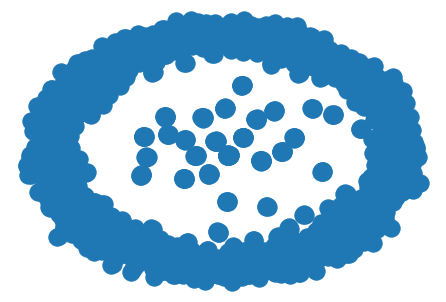

In [86]:
nx.draw(G, font_weight='bold')

In [92]:
ccs = [x for x in nx.connected_components(G)]

In [106]:
ccs

[{'books/ph/deGrootL86/Bandes86', 'conf/popl/Bandes84'},
 {'books/sp/LangCS91', 'tr/ibm/IWBS147'},
 {'books/teu/Humbert2005', 'books/teu/Humbert2006'},
 {'books/ws/phaunRS01/Immerman01', 'journals/eatcs/Immerman99'},
 {'conf/3dim/X05b', 'conf/cvpr/X05c', 'conf/iccd/X06c'},
 {'conf/ACMse/Bryfczynski08', 'conf/ACMse/Bryfczynski08a'},
 {'conf/IEEEpact/WellsCS07', 'conf/asplos/WellsCS08'},
 {'conf/IEEEpact/X05c',
  'conf/IEEEscc/X05d',
  'conf/aict/X06',
  'conf/icnp/X05d',
  'conf/sadfe/X05a'},
 {'conf/aaai/LoboMT97', 'journals/tplp/LoboMT01'},
 {'conf/aaai/RadlinskiJ06', 'journals/corr/abs-cs-0605037'},
 {'conf/aaai/XueZZ06', 'journals/toit/XueZZ08'},
 {'conf/accv/WangL06', 'journals/tits/WangL08'},
 {'conf/acsac/VignaK98', 'journals/jcs/VignaK99'},
 {'conf/acsac/X05', 'conf/icdar/X05', 'conf/icmens/X05', 'conf/icvs/X06'},
 {'conf/acsac/X05d',
  'conf/crv/X05a',
  'conf/icde/X05r',
  'conf/icdm/X05d',
  'conf/la-web/X04c',
  'conf/policy/X05b',
  'conf/sera/X05c',
  'conf/wowmom/X06c'},


In [127]:
sample_cc = ['journals/cacm/Crawford00b',
  'journals/cacm/Crawford01q',
  'journals/cacm/Crawford02u',
  'journals/cacm/Crawford03w',
  'journals/cacm/Crawford04r',
  'journals/cacm/Crawford04w',
  'journals/cacm/Crawford05XI',
  'journals/cacm/Crawford05r',
  'journals/cacm/Crawford06',
  'journals/cacm/Crawford06f',
  'journals/cacm/Crawford06p',
  'journals/cacm/Crawford07t',
  'journals/cacm/Crawford08',
  'journals/cacm/Crawford08j']

In [128]:
df_similar_pairs[(df_similar_pairs.RID1.isin(sample_cc)) | (df_similar_pairs.RID2.isin(sample_cc))]

RID1                       RID2  JaccardSimilarity  \
252   journals/cacm/Crawford00b  journals/cacm/Crawford01q                1.0   
536   journals/cacm/Crawford00b  journals/cacm/Crawford02u                1.0   
1631  journals/cacm/Crawford00b  journals/cacm/Crawford03w                1.0   
1349  journals/cacm/Crawford00b  journals/cacm/Crawford04r                1.0   
194   journals/cacm/Crawford00b  journals/cacm/Crawford04w                1.0   
...                         ...                        ...                ...   
1210  journals/cacm/Crawford06p   journals/cacm/Crawford08                1.0   
386   journals/cacm/Crawford06p  journals/cacm/Crawford08j                1.0   
1203  journals/cacm/Crawford07t   journals/cacm/Crawford08                1.0   
379   journals/cacm/Crawford07t  journals/cacm/Crawford08j                1.0   
388    journals/cacm/Crawford08  journals/cacm/Crawford08j                1.0   

                       dblp_id1   publication_title1        authors1  \
252   journals/cacm/Crawford00b  Editorial Pointers.  Diane Crawford   
536   journals/cacm/Crawford00b  Editorial Pointers.  Diane Crawford   
1631  journals/cacm/Crawford00b  Editorial Pointers.  Diane Crawford   
1349  journals/cacm/Crawford00b  Editorial Pointers.  Diane Crawford   
194   journals/cacm/Crawford00b  Editorial Pointers.  Diane Crawford   
...                         ...                  ...             ...   
1210  journals/cacm/Crawford06p  Editorial pointers.  Diane Crawford   
386   journals/cacm/Crawford06p  Editorial pointers.  Diane Crawford   
1203  journals/cacm/Crawford07t  Editorial pointers.  Diane Crawford   
379   journals/cacm/Crawford07t  Editorial pointers.  Diane Crawford   
388    journals/cacm/Crawford08  Editorial pointers.  Diane Crawford   

                                            other_info1  \
252   2003-11-20 5 2000 43 Commun. ACM 2 http //doi....   
536   2003-11-20 5 2000 43 Commun. ACM 2 http //doi....   
1631  2003-11-20 5 2000 43 Commun. ACM 2 http //doi....   
1349  2003-11-20 5 2000 43 Commun. ACM 2 http //doi....   
194   2003-11-20 5 2000 43 Commun. ACM 2 http //doi....   
...                                                 ...   
1210  2007-02-20 5 2006 49 Commun. ACM 7 http //doi....   
386   2007-02-20 5 2006 49 Commun. ACM 7 http //doi....   
1203  2007-10-30 5 2007 50 Commun. ACM 11 http //doi...   
379   2007-10-30 5 2007 50 Commun. ACM 11 http //doi...   
388   2008-01-17 5 2008 51 Commun. ACM 1 http //doi....   

                         join_attribute1                   dblp_id2  \
252   Editorial Pointers. Diane Crawford  journals/cacm/Crawford01q   
536   Editorial Pointers. Diane Crawford  journals/cacm/Crawford02u   
1631  Editorial Pointers. Diane Crawford  journals/cacm/Crawford03w   
1349  Editorial Pointers. Diane Crawford  journals/cacm/Crawford04r   
194   Editorial Pointers. Diane Crawford  journals/cacm/Crawford04w   
...                                  ...                        ...   
1210  Editorial pointers. Diane Crawford   journals/cacm/Crawford08   
386   Editorial pointers. Diane Crawford  journals/cacm/Crawford08j   
1203  Editorial pointers. Diane Crawford   journals/cacm/Crawford08   
379   Editorial pointers. Diane Crawford  journals/cacm/Crawford08j   
388   Editorial pointers. Diane Crawford  journals/cacm/Crawford08j   

       publication_title2        authors2  \
252   Editorial Pointers.  Diane Crawford   
536   Editorial pointers.  Diane Crawford   
1631  Editorial pointers.  Diane Crawford   
1349  Editorial pointers.  Diane Crawford   
194   Editorial pointers.  Diane Crawford   
...                   ...             ...   
1210  Editorial pointers.  Diane Crawford   
386   Editorial pointers.  Diane Crawford   
1203  Editorial pointers.  Diane Crawford   
379   Editorial pointers.  Diane Crawford   
388   Editorial pointers.  Diane Crawford   

                                            other_info2  \
252   2003-11-20 5 2001 44 

Benchmark:

| Trial  | Count of Records  | Percent of Total  | Matches Returned  | Time Passed             |
|--------|-------------------|-------------------|-------------------|-------------------------|
| 1      | 12713             | 1%                | 8                 | 156.05858445167542 sec  |
| 2      | 126620            | 10%               | 1717              | 2.7 hrs                 |
|        |                   |                   |                   |                         |

# Highly Connected Subgraph Clustering

In [89]:
# Adapted from https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py
def highly_connected(G, E):
    """Checks if the graph G is highly connected
    Highly connected means, that splitting the graph G into subgraphs needs more than 0.5*|V| edge deletions
    This definition can be found in Section 2 of the publication.
    :param G: Graph G
    :param E: Edges needed for splitting G
    :return: True if G is highly connected, otherwise False
    """

    return len(E) > len(G.nodes) / 2


def remove_edges(G, E):
    """Removes all edges E from G
    Iterates over all edges in E and removes them from G
    :param G: Graph to remove edges from
    :param E: One or multiple Edges
    :return: Graph with edges removed
    """

    for edge in E:
        G.remove_edge(*edge)
    return G


def HCS(G):
    """Basic HCS Algorithm
    cluster labels, removed edges are stored in global variables
    :param G: Input graph
    :return: Either the input Graph if it is highly connected, otherwise a Graph composed of
    Subgraphs that build clusters
    """

    E = nx.algorithms.connectivity.cuts.minimum_edge_cut(G)

    if not highly_connected(G, E):
        G = remove_edges(G, E)
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        if len(sub_graphs) == 2:
            H = HCS(sub_graphs[0])
            _H = HCS(sub_graphs[1])

            G = nx.compose(H, _H)

    return G

def labelled_HCS(G):
    """
    Runs basic HCS and returns Cluster Labels
    :param G: Input graph
    :return: List of cluster assignments for the single vertices
    """

    _G = HCS(G)

    sub_graphs = (G.subgraph(c).copy() for c in nx.connected_components(_G))


    labels = np.zeros(shape=(len(G)), dtype=np.uint16)

    for _class, _cluster in enumerate(sub_graphs, 1):
        c = list(_cluster.nodes)
        labels[c] = _class

    return labels

In [131]:
if nx.is_connected(G):
    G_HCS = HCS(G)
else:
    print("Input graph is not connected")

Input graph is not connected


In [132]:
# TODO: HCS subclustering on connected components, rather than entire graph, if graph is not connected